# Dolan Creek Watershed: One Watershed Water Balance - LOCA Grid

Process the LOCA grid to get area-weighting for one watershed time series processing.

**NOT COMPLETE**

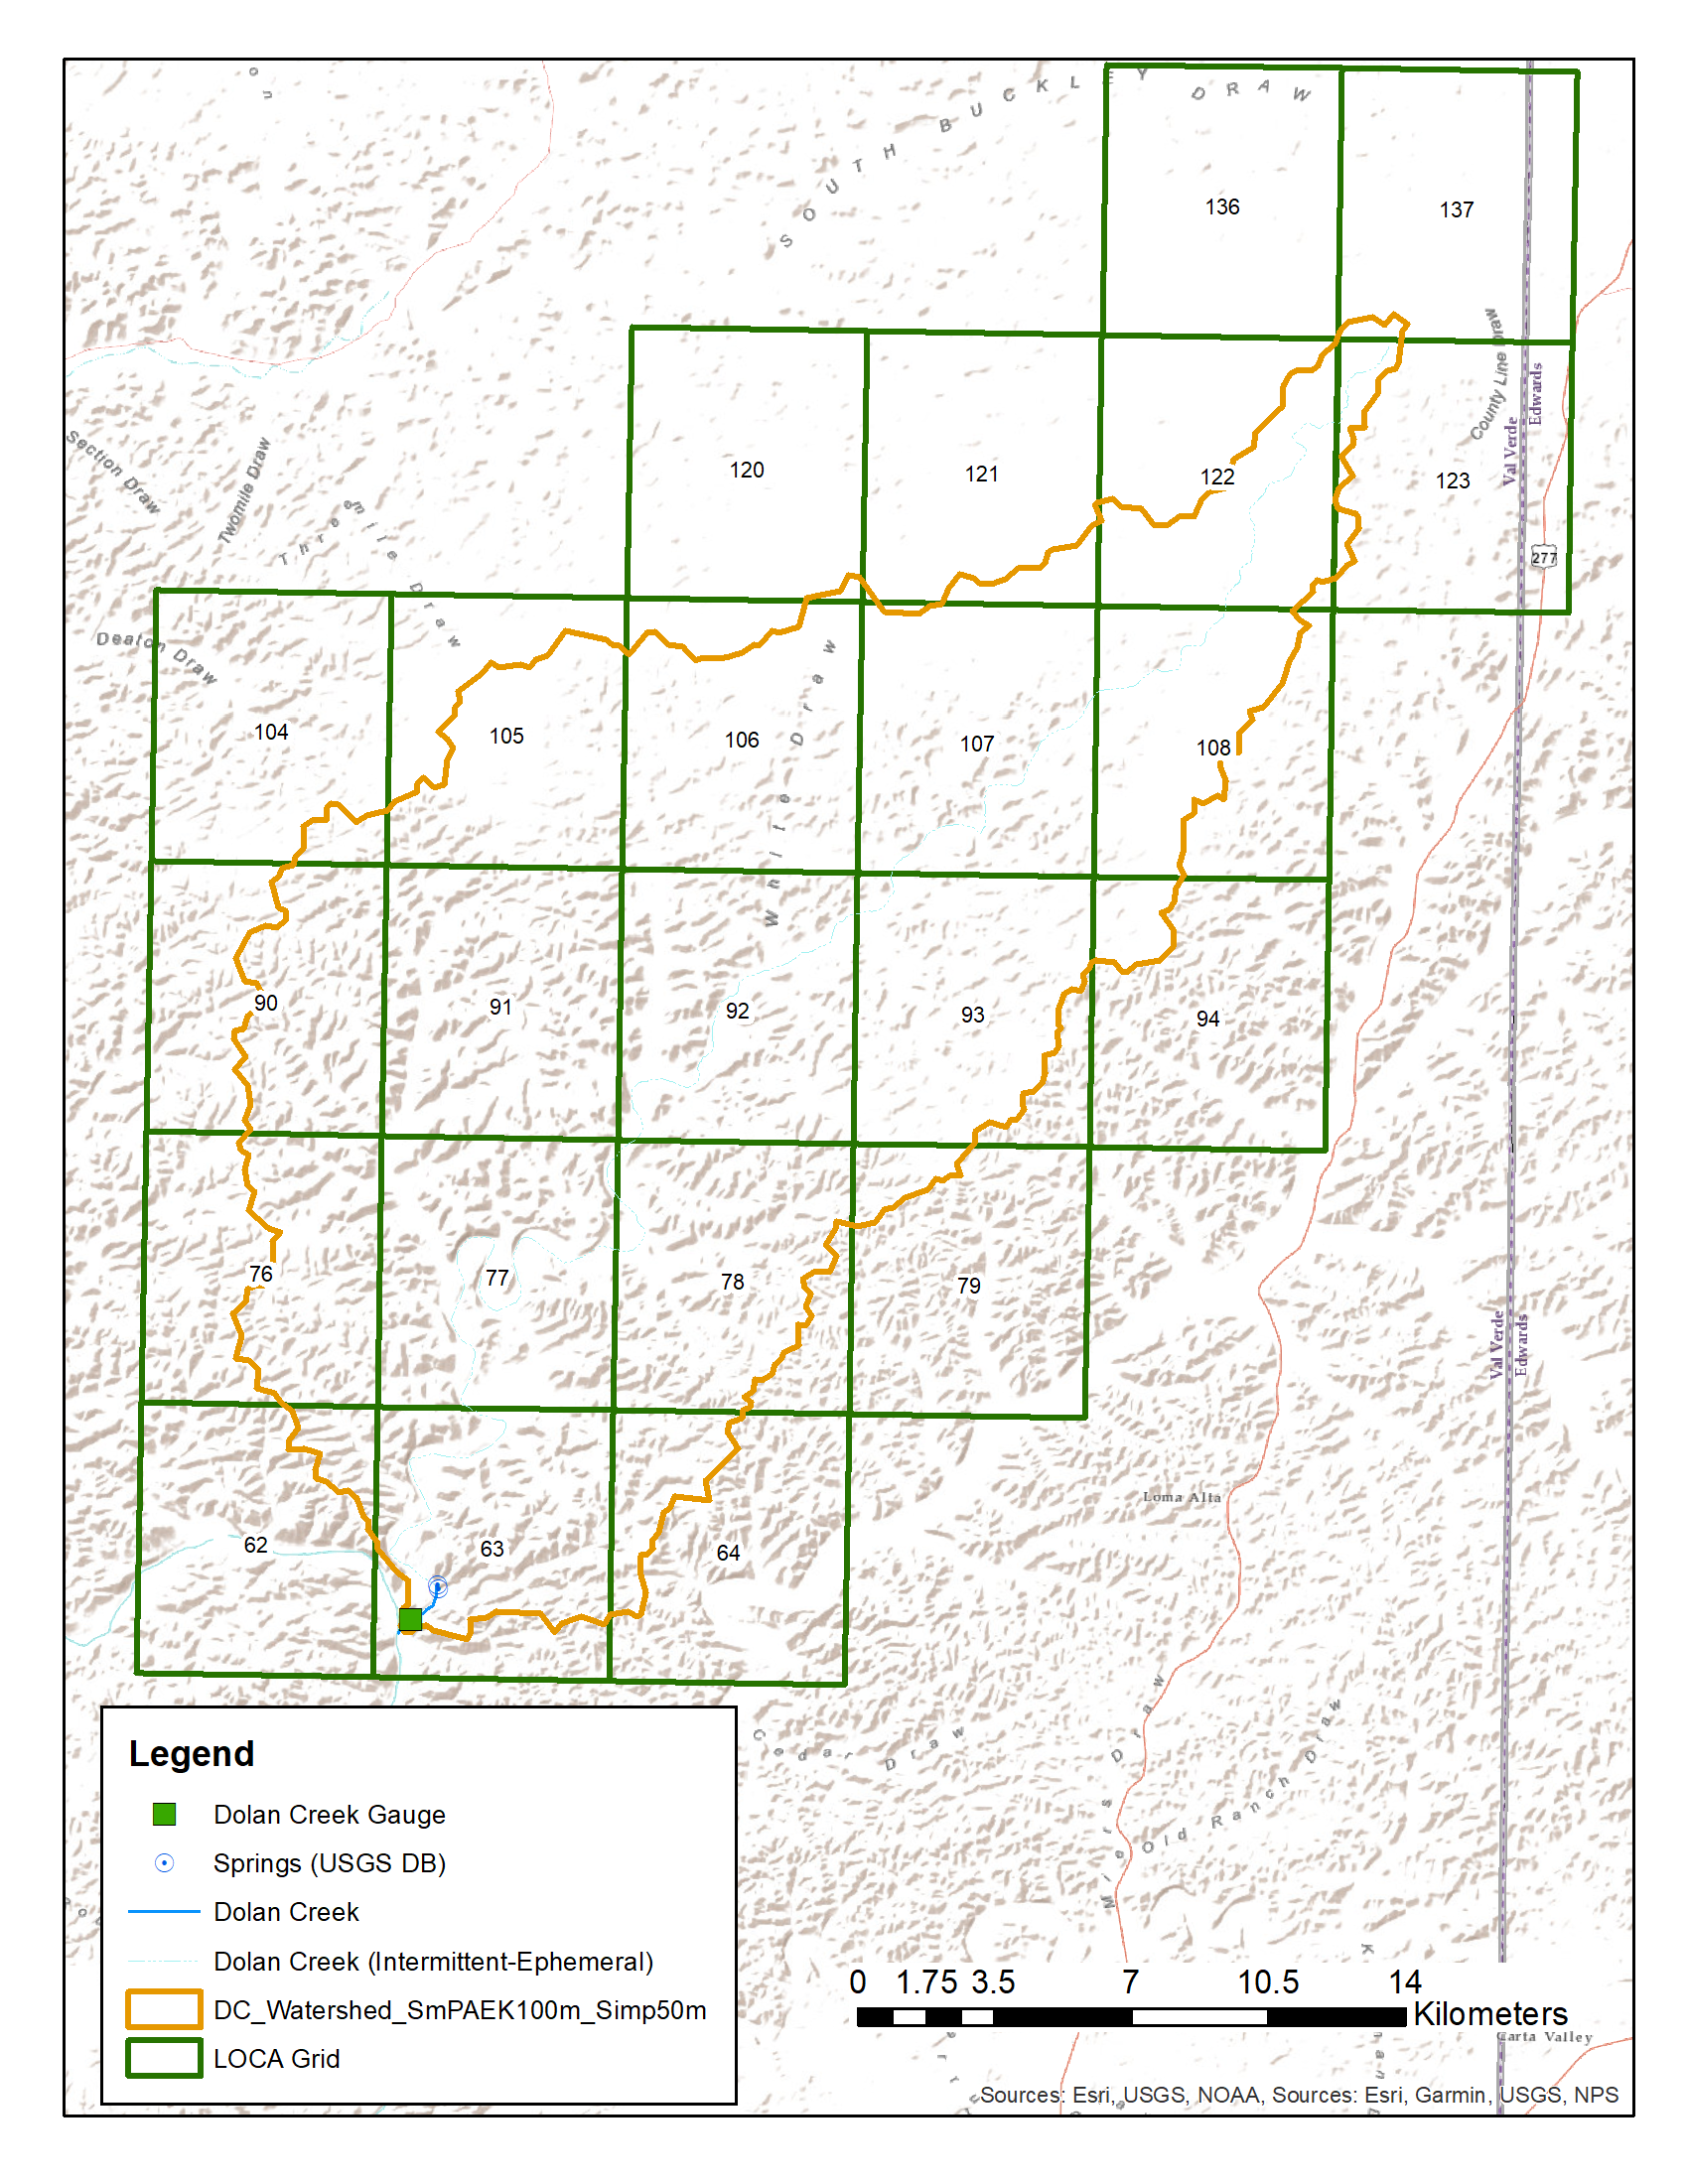

In [1]:
from IPython.display import Image
from IPython.core.display import HTML
Image(filename = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stoch' \
                 r'astic_CC_Recharge\GIS\Images\PNG\CMIP5_Climate_Grid.png', width=800)

In [2]:
%matplotlib inline

In [4]:
import os
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats as sstats
from math import exp
import geopandas as gpd

In [5]:
DC_WS_MI2 = 178.00
DC_WS_ACRE = 113919.38
DC_WS_M2 = 461015363.393

In [8]:
# shapefiles
Clip_LOCA = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\GIS\Shape' \
            r'files\LOCA_CMIP5_WSIntGrid_Clip.shp'
LOCA = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\GIS\Shape' \
       r'files\LOCA_CMIP5_WSIntGrid.shp'
WS = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\NumModel\HSPF\GIS\Sh' \
     r'apefiles\DC_Watershed_SmPAEK100m_Simp50m.shp'

In [78]:
OUT_SHP = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\NumModel\HSPF\GIS\Shapefiles' 
OUT_WS = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Recharge\Data\Weather\One_WS'

In [ ]:
PPT_IN = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Re' \
           r'charge\Data\Weather\PRISM_Daily\PRISM_AOI_Pts_ppt-Processed.xlsx'
TMIN_IN = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Re' \
          r'charge\Data\Weather\PRISM_Daily\PRISM_AOI_Pts_tmin-Processed.xlsx'
TMAX_IN = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Re' \
          r'charge\Data\Weather\PRISM_Daily\PRISM_AOI_Pts_tmax.xlsx'
TAVE_IN = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Re' \
          r'charge\Data\Weather\PRISM_Daily\PRISM_AOI_Pts_tmean.xlsx'
TDPT_IN = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Re' \
          r'charge\Data\Weather\PRISM_Daily\PRISM_AOI_Pts_tdmean.xlsx'
PRISM_SHT = "Daily"
PRISM_AREAS = r'\\augustine.space.swri.edu\jdrive\Groundwater\R8937_Stochastic_CC_Re' \
              r'charge\GIS\Tables\One_WS\PRISM_Grid_Areas.xlsx'
PA_SHT = "Areas"

## Load Shapefiles

In [7]:
gpdClip = gpd.read_file( Clip_LOCA )
gpdLoca = gpd.read_file( LOCA )
gpdLoca.crs

{'init': 'epsg:32614'}

In [9]:
gpdWS = gpd.read_file( WS )

## Calculate and Transform WS Centroid

In [15]:
OurCent = gpdWS['geometry'].centroid
type(OurCent)

geopandas.geoseries.GeoSeries

In [24]:
CentPt = OurCent.values[0]
CentPt.x, CentPt.y

(315670.666649202, 3323881.4198779054)

In [27]:
DataDict = { 'descript' : 'Dolan Creek Watershed ',
             'UTM_x' : [CentPt.x],
             'UTM_y' : [CentPt.y], }
WSCentDF = pd.DataFrame( data=DataDict )
gpdWDCent = gpd.GeoDataFrame( WSCentDF, geometry=[CentPt] )
gpdWDCent.crs = gpdLoca.crs

In [28]:
TransCRS = {'init' : 'epsg:4326' }
gpdWSCentTrans = gpdWDCent.to_crs( TransCRS )

In [29]:
PtX = lambda Pt: Pt.x
PtY = lambda Pt: Pt.y

In [30]:
gpdWSCentTrans['long_WGS'] = gpdWSCentTrans.apply( lambda row: PtX(row['geometry']), axis = 1 )
gpdWSCentTrans['lati_WGS'] = gpdWSCentTrans.apply( lambda row: PtY(row['geometry']), axis = 1 )

In [31]:
display( HTML( gpdWSCentTrans.head().to_html() ) )

,descript,UTM_x,UTM_y,geometry,long_WGS,lati_WGS
0,Dolan Creek Watershed,315670.666649,3.323881e+06,POINT (-100.91162 30.03210),-100.911622,30.032098


In [32]:
OutFiler = os.path.normpath( os.path.join( OUT_SHP, "DCWS_Centroid_WGS.shp" ) )
gpdWSCentTrans.to_file( OutFiler )

##  Calculate Area Weights

In [33]:
display( HTML( gpdLoca.head().to_html() ) )

,Join_Count,TARGET_FID,Id,Row,Col,Longitude,Lattitude,DS_Method,DS_Resolut,utm_x,utm_y,POLY_AREA,PERIMETER,CENTROID_X,CENTROID_Y,geometry
0,1,61,62,4.0,5.0,-101.03125,29.90625,LOCA,1/16th degree,303885.948818,3.310131e+06,4.177942e+07,25915.282065,303885.048830,3.310128e+06,"POLYGON ((300806.132 3306722.184, 300930.379 3313648.480, 306963.925 3313527.942, 306843.435 3306614.139, 300806.132 3306722.184))"
1,1,62,63,4.0,6.0,-100.96875,29.90625,LOCA,1/16th degree,309921.449336,3.310026e+06,4.177512e+07,25913.909776,309922.300116,3.310023e+06,"POLYGON ((306843.435 3306614.139, 306963.925 3313527.942, 312997.605 3313438.178, 312880.909 3306512.777, 306843.435 3306614.139))"
2,1,63,64,4.0,7.0,-100.90625,29.90625,LOCA,1/16th degree,315956.835298,3.309924e+06,4.180464e+07,25923.723075,315956.793931,3.309924e+06,"POLYGON ((312880.909 3306512.777, 312997.605 3313438.178, 319031.102 3313334.773, 318917.980 3306410.677, 312880.909 3306512.777))"
3,1,75,76,5.0,5.0,-101.03125,29.96875,LOCA,1/16th degree,304008.568057,3.317058e+06,4.185489e+07,25941.021108,304008.785717,3.317056e+06,"POLYGON ((300930.379 3313648.480, 301052.506 3320577.909, 307084.895 3320469.286, 306963.925 3313527.942, 300930.379 3313648.480))"
4,1,76,77,5.0,6.0,-100.96875,29.96875,LOCA,1/16th degree,310040.290335,3.316953e+06,4.180902e+07,25926.265734,310038.537555,3.316948e+06,"POLYGON ((306963.925 3313527.942, 307084.895 3320469.286, 313114.614 3320355.923, 312997.605 3313438.178, 306963.925 3313527.942))"


In [34]:
display( HTML( gpdClip.head().to_html() ) )

,Id,Row,Col,DS_Method,DS_Resolut,POLY_AREA,PERIMETER,CENTROID_X,CENTROID_Y,geometry
0,62,4.0,5.0,LOCA,1/16th degree,4.300650e+06,11093.482207,306067.872028,3.312432e+06,"POLYGON ((306963.925 3313527.942, 306904.843 3310137.764, 306710.072 3310393.207, 306745.574 3310596.089, 306611.386 3310693.678, 306441.605 3311182.274, 306220.764 3311377.052, 305985.143 3311343.526, 305644.750 3311627.085, 305410.725 3311693.083, 305362.195 3311925.760, 305513.533 3312336.685, 305096.874 3312458.924, 304691.314 3312443.411, 304711.397 3312676.711, 304951.305 3312989.809, 304795.319 3313427.654, 304569.640 3313575.775, 306963.925 3313527.942))"
1,63,4.0,6.0,LOCA,1/16th degree,3.178800e+07,23923.959707,310007.602117,3.310819e+06,"POLYGON ((312997.605 3313438.178, 312909.068 3308183.899, 312762.680 3307960.480, 312192.540 3308155.652, 311686.478 3307976.951, 311488.828 3307746.281, 311129.633 3308231.885, 309993.083 3308284.770, 309772.902 3308145.358, 309338.170 3308074.962, 309351.622 3307792.447, 309272.136 3307586.573, 308392.828 3307815.649, 308231.325 3307931.983, 307985.901 3307902.986, 307830.115 3307762.889, 307632.864 3307790.184, 307557.679 3307941.684, 307700.668 3308158.570, 307632.882 3308385.278, 307751.501 3308467.431, 307771.840 3309069.312, 307458.603 3309315.939, 306986.247 3309893.583, 306969.989 3310052.324, 306904.843 3310137.764, 306963.925 3313527.942, 312997.605 3313438.178))"
2,64,4.0,7.0,LOCA,1/16th degree,9.406563e+06,16710.819684,314115.193906,3.311558e+06,"POLYGON ((316306.109 3313381.476, 316293.467 3313245.577, 315978.570 3313125.869, 315928.701 3312894.824, 316198.790 3312450.759, 315360.657 3311652.083, 315471.105 3311125.077, 314562.616 3311225.879, 314447.037 3310924.726, 314284.664 3310819.150, 314174.006 3310324.423, 313983.042 3310095.520, 314020.582 3309893.827, 313894.867 3309768.505, 313710.661 3309746.605, 313683.311 3309306.948, 313828.904 3308775.084, 313697.866 3308214.979, 313617.374 3308165.579, 313378.084 3308285.062, 312924.818 3308207.937, 312909.068 3308183.899, 312997.605 3313438.178, 316306.109 3313381.476))"
3,76,5.0,5.0,LOCA,1/16th degree,2.234940e+07,22070.033751,305396.299050,3.317072e+06,"POLYGON ((307084.895 3320469.286, 306963.925 3313527.942, 304569.640 3313575.775, 304508.541 3313615.876, 304345.615 3313877.950, 303868.156 3314015.314, 303915.022 3314459.172, 303664.110 3314706.968, 303330.080 3314763.479, 303502.843 3315360.918, 303260.729 3315903.467, 303594.663 3316218.953, 303638.282 3316549.962, 303901.841 3316657.642, 304040.138 3316616.489, 304120.716 3316692.462, 304301.446 3317191.984, 304282.746 3317770.407, 304494.670 3317996.071, 304181.144 3318097.264, 303661.934 3318545.284, 303824.927 3319038.847, 303658.131 3319199.838, 303580.903 3319583.342, 303673.686 3319970.899, 303479.196 3320094.914, 303430.232 3320273.148, 303645.493 3320531.218, 307084.895 3320469.286))"
4,77,5.0,6.0,LOCA,1/16th degree,4.180902e+07,25926.265734,310038.537555,3.316948e+06,"POLYGON ((313114.614 3320355.923, 312997.605 3313438.178, 306963.925 3313527.942, 307084.895 3320469.286, 313114.614 3320355.923))"


In [35]:
len(gpdClip), len(gpdLoca)

(23, 23)

In [36]:
OurIndex = sorted( gpdLoca['Id'].unique() )
NumInd = len(OurIndex)
NumInd

23

In [72]:
TotArea = np.zeros( NumInd, dtype=np.float32 )
WSArea = np.zeros( NumInd, dtype=np.float32 )
MWeight = np.zeros( NumInd, dtype=np.float32 )
RelWSArea = np.zeros( NumInd, dtype=np.float32 )

In [73]:
PolyList = list()
iCnt = 0
for tInd in OurIndex:
    cTotA = float( gpdLoca['POLY_AREA'][gpdLoca['Id'] == tInd] )
    cClipA = float( gpdClip['POLY_AREA'][gpdClip['Id'] == tInd] )
    PolyList.append( gpdClip['geometry'][gpdClip['Id'] == tInd].iloc[0] )
    cWeight = cClipA / DC_WS_M2
    cRelArea = cClipA / cTotA 
    TotArea[iCnt] = cTotA
    WSArea[iCnt] = cClipA
    MWeight[iCnt] = cWeight
    RelWSArea[iCnt] = cRelArea
    iCnt += 1
# end of for

In [74]:
DataDict = { 'Cell_Id' : np.array( OurIndex, dtype=np.int32 ),
             'Tot_Area' : TotArea,
             'Clp_Area' : WSArea,
             'Weight' : MWeight, 
             'Rel_WS' : RelWSArea, }
WSWghtDF = pd.DataFrame( data=DataDict )
Acopy = WSWghtDF.copy()
gpdWSWghtDF = gpd.GeoDataFrame( Acopy, geometry=PolyList )
gpdWSWghtDF.crs = gpdLoca.crs

In [75]:
display( HTML( WSWghtDF.head().to_html() ))

,Cell_Id,Tot_Area,Clp_Area,Weight,Rel_WS
0,62,41779420.0,4300649.5,0.009329,0.102937
1,63,41775124.0,31788004.0,0.068952,0.760931
2,64,41804636.0,9406563.0,0.020404,0.225012
3,76,41854892.0,22349400.0,0.048479,0.533973
4,77,41809020.0,41809020.0,0.090689,1.000000


In [76]:
display( HTML( gpdWSWghtDF.head().to_html() ))

,Cell_Id,Tot_Area,Clp_Area,Weight,Rel_WS,geometry
0,62,41779420.0,4300649.5,0.009329,0.102937,"POLYGON ((306963.925 3313527.942, 306904.843 3310137.764, 306710.072 3310393.207, 306745.574 3310596.089, 306611.386 3310693.678, 306441.605 3311182.274, 306220.764 3311377.052, 305985.143 3311343.526, 305644.750 3311627.085, 305410.725 3311693.083, 305362.195 3311925.760, 305513.533 3312336.685, 305096.874 3312458.924, 304691.314 3312443.411, 304711.397 3312676.711, 304951.305 3312989.809, 304795.319 3313427.654, 304569.640 3313575.775, 306963.925 3313527.942))"
1,63,41775124.0,31788004.0,0.068952,0.760931,"POLYGON ((312997.605 3313438.178, 312909.068 3308183.899, 312762.680 3307960.480, 312192.540 3308155.652, 311686.478 3307976.951, 311488.828 3307746.281, 311129.633 3308231.885, 309993.083 3308284.770, 309772.902 3308145.358, 309338.170 3308074.962, 309351.622 3307792.447, 309272.136 3307586.573, 308392.828 3307815.649, 308231.325 3307931.983, 307985.901 3307902.986, 307830.115 3307762.889, 307632.864 3307790.184, 307557.679 3307941.684, 307700.668 3308158.570, 307632.882 3308385.278, 307751.501 3308467.431, 307771.840 3309069.312, 307458.603 3309315.939, 306986.247 3309893.583, 306969.989 3310052.324, 306904.843 3310137.764, 306963.925 3313527.942, 312997.605 3313438.178))"
2,64,41804636.0,9406563.0,0.020404,0.225012,"POLYGON ((316306.109 3313381.476, 316293.467 3313245.577, 315978.570 3313125.869, 315928.701 3312894.824, 316198.790 3312450.759, 315360.657 3311652.083, 315471.105 3311125.077, 314562.616 3311225.879, 314447.037 3310924.726, 314284.664 3310819.150, 314174.006 3310324.423, 313983.042 3310095.520, 314020.582 3309893.827, 313894.867 3309768.505, 313710.661 3309746.605, 313683.311 3309306.948, 313828.904 3308775.084, 313697.866 3308214.979, 313617.374 3308165.579, 313378.084 3308285.062, 312924.818 3308207.937, 312909.068 3308183.899, 312997.605 3313438.178, 316306.109 3313381.476))"
3,76,41854892.0,22349400.0,0.048479,0.533973,"POLYGON ((307084.895 3320469.286, 306963.925 3313527.942, 304569.640 3313575.775, 304508.541 3313615.876, 304345.615 3313877.950, 303868.156 3314015.314, 303915.022 3314459.172, 303664.110 3314706.968, 303330.080 3314763.479, 303502.843 3315360.918, 303260.729 3315903.467, 303594.663 3316218.953, 303638.282 3316549.962, 303901.841 3316657.642, 304040.138 3316616.489, 304120.716 3316692.462, 304301.446 3317191.984, 304282.746 3317770.407, 304494.670 3317996.071, 304181.144 3318097.264, 303661.934 3318545.284, 303824.927 3319038.847, 303658.131 3319199.838, 303580.903 3319583.342, 303673.686 3319970.899, 303479.196 3320094.914, 303430.232 3320273.148, 303645.493 3320531.218, 307084.895 3320469.286))"
4,77,41809020.0,41809020.0,0.090689,1.000000,"POLYGON ((313114.614 3320355.923, 312997.605 3313438.178, 306963.925 3313527.942, 307084.895 3320469.286, 313114.614 3320355.923))"


In [77]:
# output
OutFiler = os.path.normpath( os.path.join( OUT_SHP, "DCWS_LOCA_Weights.shp" ) )
gpdWSWghtDF.to_file( OutFiler )